### Write a class with the following functions: 
- gp_model()
- minimize()
- set_initial_state()
- stim_state = sample()
- state_est = predict_state()
- transition_stete()


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [30]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)

        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, X0_coords, U1, X1, lower_bound, upper_bound, X0_psd):
        # input_data
        U1_X0 = U1.join(X0_psd)
        #GP model
        # define kernel
        ker = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(3)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1_X0,X1,ker)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(2, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel='Stim. Amp.', title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,U1_X0, m):
        #TODO: take X0_psd instead of U1_X0
        
        # Instead of sorting the freq. and amp. in ascending order, sort by rise in gamma up to sample 50 and then fall in gamma.
        
        rand_freq_1d = np.random.choice([5,7,11,17, 23, 35, 42], size=(100))
        rand_freq_1d_sorted = np.sort(rand_freq_1d)
        print(rand_freq_1d_sorted[0:3])
        rand_amp_1d = np.random.choice([10,20,30,40,50], size=(100))
        rand_amp_1d_sorted = np.sort(rand_amp_1d)
        print(rand_amp_1d_sorted[0:3])
        
        hill_sum_preStim_gamma = np.empty((100))
        min_sum_preStim_gamma = np.min(U1_X0['sum_preStim_gamma'])
        max_sum_preStim_gamma = np.max(U1_X0['sum_preStim_gamma'])
        step_size = (max_sum_preStim_gamma-min_sum_preStim_gamma)/50
        hill_sum_preStim_gamma[0:50] = np.arange(min_sum_preStim_gamma, max_sum_preStim_gamma, step_size)
        hill_sum_preStim_gamma[50:100] = np.arange(max_sum_preStim_gamma,min_sum_preStim_gamma, -step_size)
        testX = np.array([rand_freq_1d, rand_amp_1d, hill_sum_preStim_gamma])
        print(np.shape(testX))
        testX = np.transpose(testX)
        print(testX[98:99,0:3])
        
        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        posteriorTestY = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
            # print(np.shape(m.predict(testX)))
        simY, simMse = m.predict(testX)

        print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # posteriorTestY
        print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        print(np.shape(simY),'\n', np.shape(simMse))
        
        # plt.plot(posteriorTestY)
        plt.plot(simY[:, 0], 'b-')
        plt.plot(simY[:, 0] + simMse[:, 0]** 0.5, 'c--')
        plt.plot(simY[:, 0] - simMse[:, 0]** 0.5, 'c--')
        plt.plot(hill_sum_preStim_gamma, 'k-')
        plt.ylabel('mean predicted gamma power [*e-10]')
        plt.xlabel('random sample')
        plt.title('Prediction for hill shape min-to-max preStim Gamma')
        plt.legend(['Mean','MSE', 'X0'])
        plt.show()

        return posteriorTestY, simY, simMse;
        
    

In [31]:
model = state_dr_gp()

In [32]:
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d01e4e08e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d01e4b82e0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0001   3.885537e+03   7.418182e+05 
    00s17  0003   2.369277e+03   8.238841e+04 
    01s21  0020   1.113082e+03   3.966551e-01 
    01s92  0034   1.111442e+03   3.171993e-09 
Runtime:     01s92
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d01ec20790>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d01edf92b0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d01e458850>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d01e44e580>]}

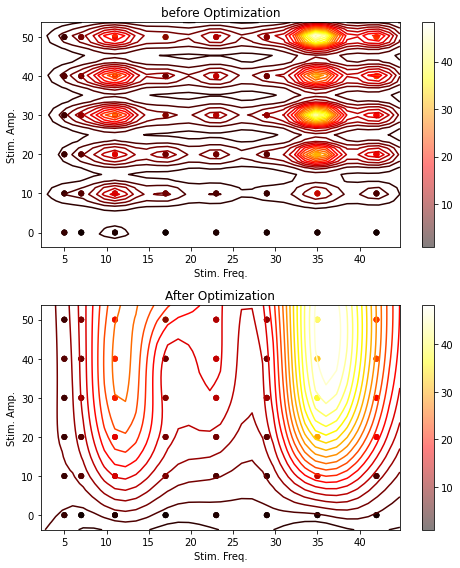

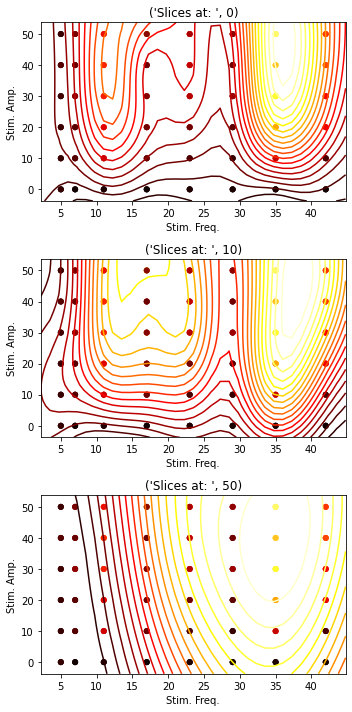

In [33]:
U1_X0, y, trained_model = model.initialize_data_dr_sim(X0_coords, U1, X1, lower_bound, upper_bound, X0_psd)
# print(x)

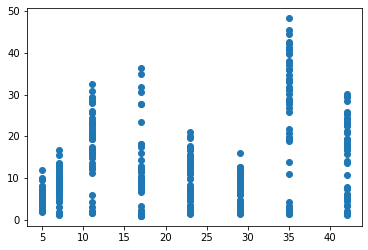

In [34]:
plt.scatter(U1_X0['Stim_1'],y)

[5 5 5]
[10 10 10]
(3, 100)
[[ 5.         50.          1.22121269]]
mean is: 
 [18.51111435] 

 Variance is: 
 [15.50764763]
(100,) 
 [20.21247198  6.52498498  5.71635249 13.72688379  4.89394353 22.55714104
  4.81421351 29.92514071 16.38273558 23.95921391]
(100, 1) 
 (100, 1)


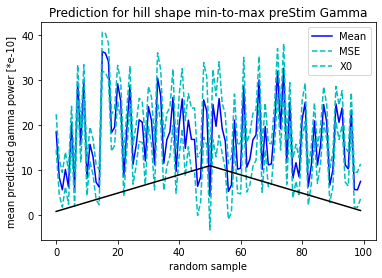

In [35]:
posteriorTestY, simY, simMse = model.sample(U1_X0, trained_model)